# Importing Libraries and predictions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import os
os.chdir('../')
from utilities import plot,errors

In [2]:
os.chdir('notebooks/')

In [3]:
s2p_mlp_training = pd.read_csv('fridge/s2p/mlp/training_predictions.csv')
s2p_mlp_testing = pd.read_csv('fridge/s2p/mlp/testing_predictions.csv')
s2p_gmlp_training = pd.read_csv('fridge/s2p/gmlp/training_predictions.csv')
s2p_gmlp_testing = pd.read_csv('fridge/s2p/gmlp/testing_predictions.csv')

In [4]:
lstm_mlp_training = pd.read_csv('fridge/lstm/mlp/training_predictions.csv')
lstm_mlp_testing = pd.read_csv('fridge/lstm/mlp/testing_predictions.csv')
lstm_gmlp_training = pd.read_csv('fridge/lstm/gmlp/training_predictions.csv')
lstm_gmlp_testing = pd.read_csv('fridge/lstm/gmlp/testing_predictions.csv')

In [5]:
s2p_mlp_training.columns = map(str.lower, s2p_mlp_training.columns)
s2p_mlp_testing.columns = map(str.lower, s2p_mlp_testing.columns)
s2p_gmlp_training.columns = map(str.lower, s2p_gmlp_training.columns)
s2p_gmlp_testing.columns = map(str.lower, s2p_gmlp_testing.columns)

In [6]:
lstm_mlp_training.columns = map(str.lower, lstm_mlp_training.columns)
lstm_mlp_testing.columns = map(str.lower, lstm_mlp_testing.columns)
lstm_gmlp_training.columns = map(str.lower, lstm_gmlp_training.columns)
lstm_gmlp_testing.columns = map(str.lower, lstm_gmlp_testing.columns)

# Define Functions

In [7]:
import jax
def rmse_(dataframe):
    def rmse_loss(y,yhat):
      return (y-yhat)**2
    return jnp.mean(jax.vmap(rmse_loss,in_axes=(0,0))(dataframe['Ideal'].values,dataframe['Counts'].values))
def mae_(dataframe):
    def mae(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(mae,in_axes=(0,0))(dataframe['Ideal'].values,dataframe['Counts'].values))

In [8]:
import scipy.stats as st
def calibrate(mean, sigma, Y):
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    k = jnp.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts
    return df2

In [9]:

def something2(tr_df,te_df):
    for i in grp:
        try:
            q = tr_df[i+'sigma']
            tr_nll.append(errors.NLL(tr_df[i+'mean'].values,tr_df[i+'sigma'].values,tr_df['ground truth'].values))
            te_nll.append(errors.NLL(te_df[i+'mean'].values,te_df[i+'sigma'].values,te_df['ground truth'].values))
            df =  calibrate(tr_df[i+'mean'].values,tr_df[i+'sigma'].values,tr_df['ground truth'].values)
            tr_l1_ce.append(mae_(df))
            tr_l2_ce.append(rmse_(df))
            df =  calibrate(te_df[i+'mean'].values,te_df[i+'sigma'].values,te_df['ground truth'].values)
            te_l1_ce.append(mae_(df))
            te_l2_ce.append(rmse_(df))
            
        except:
            tr_nll.append(0)
            te_nll.append(0)
            tr_l1_ce.append(0)
            tr_l2_ce.append(0)
            te_l1_ce.append(0)
            te_l2_ce.append(0)
            

def something(tr_df,te_df):
    for i in grp:
        
            tr_rmse.append((errors.rmse(tr_df['ground truth'].values,tr_df[i+'mean'].values)))
            te_rmse.append((errors.rmse(te_df['ground truth'].values,te_df[i+'mean'].values)))
            tr_mae.append((errors.mae(tr_df['ground truth'].values,tr_df[i+'mean'].values)))
            te_mae.append((errors.mae(te_df['ground truth'].values,te_df[i+'mean'].values)))



# Table

In [10]:
fridge_metric  =pd.DataFrame({'approach':[],'Tr_mae':[],'Te_mae':[],'Tr_rmse':[],'Te_rmse':[],'Tr_nll':[],'Te_nll':[],
'Tr_l1_ce':[],'Te_l1_ce':[],'Tr_l2_ce':[],'Te_l2_ce':[]})
row1 = {'approach':['s2p','s2p+mc','s2p+de','s2p+bs','gs2p','gs2p+mc','gs2p+de','gs2p+bs',
'lstm','lstm+mc','lstm+de','lstm+bs','glstm','glstm+mc','glstm+de','glstm+bs']}
grp = ['','mc_','de_','bs_']
tr_rmse,te_rmse = [],[]
tr_mae,te_mae = [],[]
tr_nll,te_nll = [],[]
tr_l1_ce,te_l1_ce = [],[]
tr_l2_ce,te_l2_ce = [],[]
row1 = pd.DataFrame(row1)
fridge_metric = pd.concat([fridge_metric,row1],ignore_index=True)


In [11]:
something(s2p_mlp_training,s2p_mlp_testing)
something(s2p_gmlp_training,s2p_gmlp_testing)
something(lstm_mlp_training,lstm_mlp_testing)
something(lstm_gmlp_training,lstm_gmlp_testing)
something2(s2p_mlp_training,s2p_mlp_testing)
something2(s2p_gmlp_training,s2p_gmlp_testing)
something2(lstm_mlp_training,lstm_mlp_testing)
something2(lstm_gmlp_training,lstm_gmlp_testing)
fridge_metric['Tr_rmse']=tr_rmse
fridge_metric['Te_rmse']=te_rmse
fridge_metric['Tr_mae']=tr_mae
fridge_metric['Te_mae']=te_mae
fridge_metric['Tr_nll']=tr_nll
fridge_metric['Te_nll']=te_nll
fridge_metric['Tr_l1_ce']=tr_l1_ce
fridge_metric['Te_l1_ce']=te_l1_ce	
fridge_metric['Tr_l2_ce']=tr_l2_ce
fridge_metric['Te_l2_ce']=te_l2_ce	

In [12]:
fridge_metric

,approach,Tr_mae,Te_mae,Tr_rmse,Te_rmse,Tr_nll,Te_nll,Tr_l1_ce,Te_l1_ce,Tr_l2_ce,Te_l2_ce
0,s2p,4.805495,26.164503,8.591901,43.14318,0,0,0,0,0,0
1,s2p+mc,5.1668887,26.227226,9.046821,43.071095,3.153952,13.689155,0.0428469,0.21222867,0.0026406567,0.06749219
2,s2p+de,2.8739786,24.73768,5.3635015,41.87521,2.6537025,7.3486633,0.10848683,0.22495951,0.016830474,0.06924522
3,s2p+bs,3.7933722,24.694315,8.430231,42.02794,2.4105766,7.175089,0.14053813,0.2130792,0.027711885,0.06312443
4,gs2p,17.525785,26.912699,36.071484,45.175007,3.8042507,4.7252884,0.074195266,0.11677439,0.00788967,0.018692583
5,gs2p+mc,16.617514,26.384981,36.377296,45.549572,3.3909426,4.504261,0.13316645,0.053813577,0.02477555,0.003908152
6,gs2p+de,17.46584,26.914259,35.341267,44.84052,3.967747,4.5785184,0.020358628,0.037752118,0.0007452462,0.0022575052
7,gs2p+bs,16.631302,26.686327,35.799675,45.506622,3.3753905,4.2980843,0.14627719,0.02902904,0.029111145,0.001278118
8,lstm,23.134506,36.513454,42.645927,55.22749,0,0,0,0,0,0
9,lstm+mc,23.192966,36.570217,42.655743,55.22891,92.57637,170.37944,0.25769824,0.30675116,0.094047874,0.12976679


dishwasher

In [18]:
s2p_mlp_training = pd.read_csv('dishwasher/s2p/mlp/training_predictions.csv')
s2p_mlp_testing = pd.read_csv('dishwasher/s2p/mlp/testing_predictions.csv')
s2p_gmlp_training = pd.read_csv('dishwasher/s2p/gmlp/training_predictions.csv')
s2p_gmlp_testing = pd.read_csv('dishwasher/s2p/gmlp/testing_predictions.csv')

In [21]:
lstm_mlp_training = pd.read_csv('dishwasher/lstm/mlp/training_predictions.csv')
lstm_mlp_testing = pd.read_csv('dishwasher/lstm/mlp/testing_predictions.csv')
lstm_gmlp_training = pd.read_csv('dishwasher/lstm/gmlp/training_predictions.csv')
lstm_gmlp_testing = pd.read_csv('dishwasher/lstm/gmlp/testing_predictions.csv')

In [22]:
s2p_mlp_training.columns = map(str.lower, s2p_mlp_training.columns)
s2p_mlp_testing.columns = map(str.lower, s2p_mlp_testing.columns)
s2p_gmlp_training.columns = map(str.lower, s2p_gmlp_training.columns)
s2p_gmlp_testing.columns = map(str.lower, s2p_gmlp_testing.columns)

In [23]:
lstm_mlp_training.columns = map(str.lower, lstm_mlp_training.columns)
lstm_mlp_testing.columns = map(str.lower, lstm_mlp_testing.columns)
lstm_gmlp_training.columns = map(str.lower, lstm_gmlp_training.columns)
lstm_gmlp_testing.columns = map(str.lower, lstm_gmlp_testing.columns)

In [24]:
dish_metric  = pd.DataFrame({'approach':[],'Tr_mae':[],'Te_mae':[],'Tr_rmse':[],'Te_rmse':[],'Tr_nll':[],'Te_nll':[],
'Tr_l1_ce':[],'Te_l1_ce':[],'Tr_l2_ce':[],'Te_l2_ce':[]})
row1 = {'approach':['s2p','s2p+mc','s2p+de','s2p+bs','gs2p','gs2p+mc','gs2p+de','gs2p+bs',
'lstm','lstm+mc','lstm+de','lstm+bs','glstm','glstm+mc','glstm+de','glstm+bs']}
grp = ['','mc_','de_','bs_']
tr_rmse,te_rmse = [],[]
tr_mae,te_mae = [],[]
tr_nll,te_nll = [],[]
tr_l1_ce,te_l1_ce = [],[]
tr_l2_ce,te_l2_ce = [],[]
row1 = pd.DataFrame(row1)
dish_metric = pd.concat([dish_metric,row1],ignore_index=True)


In [25]:
something(s2p_mlp_training,s2p_mlp_testing)
something(s2p_gmlp_training,s2p_gmlp_testing)
something(lstm_mlp_training,lstm_mlp_testing)
something(lstm_gmlp_training,lstm_gmlp_testing)
something2(s2p_mlp_training,s2p_mlp_testing)
something2(s2p_gmlp_training,s2p_gmlp_testing)
something2(lstm_mlp_training,lstm_mlp_testing)
something2(lstm_gmlp_training,lstm_gmlp_testing)
dish_metric['Tr_rmse']=tr_rmse
dish_metric['Te_rmse']=te_rmse
dish_metric['Tr_mae']=tr_mae
dish_metric['Te_mae']=te_mae
dish_metric['Tr_nll']=tr_nll
dish_metric['Te_nll']=te_nll
dish_metric['Tr_l1_ce']=tr_l1_ce
dish_metric['Te_l1_ce']=te_l1_ce	
dish_metric['Tr_l2_ce']=tr_l2_ce
dish_metric['Te_l2_ce']=te_l2_ce	

In [26]:
dish_metric

,approach,Tr_mae,Te_mae,Tr_rmse,Te_rmse,Tr_nll,Te_nll,Tr_l1_ce,Te_l1_ce,Tr_l2_ce,Te_l2_ce
0,s2p,1.5949644,12.850381,9.507037,88.49798,0,0,0,0,0,0
1,s2p+mc,1.6787405,12.976092,10.141713,88.60537,103187350000.0,655179800000000.0,0.4277076,0.40377784,0.2502234,0.24908985
2,s2p+de,1.0242324,12.469606,5.0128126,78.47943,11.079867,17.20166,0.304741,0.35932204,0.13558258,0.1949358
3,s2p+bs,1.0680155,11.494465,5.7702885,80.5317,1.8355067,2.379261,0.21258175,0.049309004,0.06360404,0.004282407
4,gs2p,12.358407,9.611411,85.69681,92.050865,2.0192528,1.6614789,0.1774255,0.18010639,0.045318298,0.04967061
5,gs2p+mc,11.727242,9.26328,86.72219,92.75131,1.3942773,1.4390576,0.042701196,0.08421981,0.0026623008,0.011240692
6,gs2p+de,13.327053,9.884347,86.85015,94.226074,2.0506244,2.7752597,0.094630495,0.20175362,0.015947107,0.061199516
7,gs2p+bs,14.054095,10.218867,89.32169,93.88665,3.580455,3.5430791,0.37891597,0.36204535,0.2190192,0.19606955
8,lstm,9.06348,12.292727,38.327812,68.59398,0,0,0,0,0,0
9,lstm+mc,9.07119,12.295071,38.404182,68.58845,438.46326,1014.72296,0.38695708,0.40623987,0.2271589,0.25342


microwave

In [27]:
s2p_mlp_training = pd.read_csv('microwave/s2p/mlp/training_predictions.csv')
s2p_mlp_testing = pd.read_csv('microwave/s2p/mlp/testing_predictions.csv')
s2p_gmlp_training = pd.read_csv('microwave/s2p/gmlp/training_predictions.csv')
s2p_gmlp_testing = pd.read_csv('microwave/s2p/gmlp/testing_predictions.csv')

In [28]:
lstm_mlp_training = pd.read_csv('microwave/lstm/mlp/training_predictions.csv')
lstm_mlp_testing = pd.read_csv('microwave/lstm/mlp/testing_predictions.csv')
lstm_gmlp_training = pd.read_csv('microwave/lstm/gmlp/training_predictions.csv')
lstm_gmlp_testing = pd.read_csv('microwave/lstm/gmlp/testing_predictions.csv')

In [29]:
s2p_mlp_training.columns = map(str.lower, s2p_mlp_training.columns)
s2p_mlp_testing.columns = map(str.lower, s2p_mlp_testing.columns)
s2p_gmlp_training.columns = map(str.lower, s2p_gmlp_training.columns)
s2p_gmlp_testing.columns = map(str.lower, s2p_gmlp_testing.columns)

In [30]:
lstm_mlp_training.columns = map(str.lower, lstm_mlp_training.columns)
lstm_mlp_testing.columns = map(str.lower, lstm_mlp_testing.columns)
lstm_gmlp_training.columns = map(str.lower, lstm_gmlp_training.columns)
lstm_gmlp_testing.columns = map(str.lower, lstm_gmlp_testing.columns)

In [31]:
microwave_metric  = pd.DataFrame({'approach':[],'Tr_mae':[],'Te_mae':[],'Tr_rmse':[],'Te_rmse':[],'Tr_nll':[],'Te_nll':[],
'Tr_l1_ce':[],'Te_l1_ce':[],'Tr_l2_ce':[],'Te_l2_ce':[]})
row1 = {'approach':['s2p','s2p+mc','s2p+de','s2p+bs','gs2p','gs2p+mc','gs2p+de','gs2p+bs',
'lstm','lstm+mc','lstm+de','lstm+bs','glstm','glstm+mc','glstm+de','glstm+bs']}
grp = ['','mc_','de_','bs_']
tr_rmse,te_rmse = [],[]
tr_mae,te_mae = [],[]
tr_nll,te_nll = [],[]
tr_l1_ce,te_l1_ce = [],[]
tr_l2_ce,te_l2_ce = [],[]
row1 = pd.DataFrame(row1)
microwave_metric = pd.concat([microwave_metric,row1],ignore_index=True)


In [32]:
something(s2p_mlp_training,s2p_mlp_testing)
something(s2p_gmlp_training,s2p_gmlp_testing)
something(lstm_mlp_training,lstm_mlp_testing)
something(lstm_gmlp_training,lstm_gmlp_testing)
something2(s2p_mlp_training,s2p_mlp_testing)
something2(s2p_gmlp_training,s2p_gmlp_testing)
something2(lstm_mlp_training,lstm_mlp_testing)
something2(lstm_gmlp_training,lstm_gmlp_testing)
microwave_metric['Tr_rmse']=tr_rmse
microwave_metric['Te_rmse']=te_rmse
microwave_metric['Tr_mae']=tr_mae
microwave_metric['Te_mae']=te_mae
microwave_metric['Tr_nll']=tr_nll
microwave_metric['Te_nll']=te_nll
microwave_metric['Tr_l1_ce']=tr_l1_ce
microwave_metric['Te_l1_ce']=te_l1_ce	
microwave_metric['Tr_l2_ce']=tr_l2_ce
microwave_metric['Te_l2_ce']=te_l2_ce	

In [33]:
microwave_metric

,approach,Tr_mae,Te_mae,Tr_rmse,Te_rmse,Tr_nll,Te_nll,Tr_l1_ce,Te_l1_ce,Tr_l2_ce,Te_l2_ce
0,s2p,2.6634378,11.185808,21.998465,79.72997,0,0,0,0,0,0
1,s2p+mc,2.728726,11.174248,21.450102,79.869736,6002372000000.0,611580000000000.0,0.42440945,0.47798696,0.24597801,0.31944403
2,s2p+de,2.1759636,11.16834,14.281735,78.379105,14.269382,1716.842,0.3254203,0.39264646,0.1676792,0.21350998
3,s2p+bs,2.9391656,11.254164,24.874496,77.65649,2.0234873,151.13048,0.15138544,0.27009687,0.032324705,0.10289354
4,gs2p,7.6596737,12.463739,88.40875,101.65248,1.4506961,95.31384,0.059801135,0.03200052,0.007573258,0.0020212107
5,gs2p+mc,7.4150567,12.560314,88.67215,101.86559,1.2347395,135.65884,0.12423625,0.07764088,0.021802992,0.010067195
6,gs2p+de,14.125846,12.524833,89.10583,101.0336,2.3728287,35.2812,0.13940398,0.12767106,0.031052869,0.023286322
7,gs2p+bs,8.017901,13.274323,88.26325,101.55706,2.9592628,6.9476523,0.3500448,0.14460444,0.1791425,0.036983218
8,lstm,7.3846245,16.769403,43.665623,88.36018,0,0,0,0,0,0
9,lstm+mc,7.420004,16.7785,43.671787,88.369156,121.93306,2197.4915,0.23424366,0.374971,0.08194164,0.2035477


# Analysis

In [34]:
from probml_utils import latexify, savefig, is_latexify_enabled
import matplotlib.patches as mpatches
import numpy as np

In [39]:
%env LATEXIFY=1
%env FIG_DIR=figures/

env: LATEXIFY=1
env: FIG_DIR=figures/


In [40]:
latexify(fig_width=7)

In [41]:
def rect(i, col, metric, ax):
    hs = ax.scatter(metric.iloc[i:i+4]['Te_mae'], metric.iloc[i:i+4]['Te_l1_ce'], 
                    c=np.arange(4), s=20, cmap="rainbow")
    rect_cord=[(metric.iloc[i]['Te_mae'],metric.iloc[i]['Te_l1_ce']),
            (metric.iloc[i+1]['Te_mae'],metric.iloc[i+1]['Te_l1_ce']),
            (metric.iloc[i+2]['Te_mae'],metric.iloc[i+2]['Te_l1_ce']),
            (metric.iloc[i+3]['Te_mae'],metric.iloc[i+3]['Te_l1_ce'])]
  
    ax.add_patch(
        plt.Polygon(rect_cord, color =col,alpha = 0.2)
        )
    return hs

/home/rohit_khoiwal/anaconda3/lib/python3.9/site-packages/probml_utils/plotting.py:69: UserWarning: renaming figures/mae_ece.pdf to figures/mae_ece_latexified.pdf because LATEXIFY is True
  warnings.warn(
/home/rohit_khoiwal/anaconda3/lib/python3.9/site-packages/probml_utils/plotting.py:93: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=pad_inches)


saving image to figures/mae_ece_latexified.pdf
Figure size: [7.  1.5]


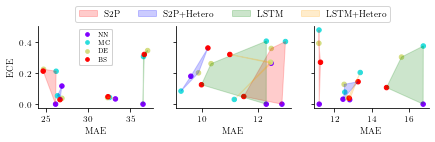

In [44]:
fig, ax= plt.subplots(1,3, sharey=True)

red_patch = mpatches.Patch(color='red',alpha=0.2, label='S2P')
blue_patch = mpatches.Patch(color='blue',alpha=0.2, label='S2P+Hetero')
green_patch= mpatches.Patch(color='green',alpha=0.2, label='LSTM')
orange_patch = mpatches.Patch(color='orange',alpha=0.2, label='LSTM+Hetero')

_ = rect(0,'red', fridge_metric, ax[0])
_ = rect(4,'blue', fridge_metric, ax[0])
_ = rect(8,'green', fridge_metric, ax[0])
hs = rect(12,'orange', fridge_metric, ax[0])
h = ax[0].legend(hs.legend_elements()[0], ["NN","MC","DE",'BS'], loc="upper center", fontsize=6,
                markerscale=0.6)
ax[0].add_artist(h)

ax[0].set_ylabel("ECE")
ax[0].set_xlabel("MAE")
# ax[0].legend(handles=[red_patch,blue_patch,green_patch,orange_patch], ncol=4, bbox_to_anchor=(0.98, 1.2))
# fig.legend(handles=[red_patch,blue_patch,green_patch,orange_patch], ncol=4, bbox_to_anchor=(0.85, 1.2))


#2
_ = rect(0,'red', dish_metric, ax[1])
_ = rect(4,'blue', dish_metric, ax[1])
_ = rect(8,'green', dish_metric, ax[1])
hs = rect(12,'orange', dish_metric, ax[1])
# h = ax[1].legend(hs.legend_elements()[0], ["simple","mc","ds",'bs'], loc="upper center")
# ax[1].add_artist(h)

ax[1].set_xlabel("MAE")
# ax[1].legend(handles=[red_patch,blue_patch,green_patch,orange_patch], ncol=4, bbox_to_anchor=(0.98, 1.2))

#3
_ = rect(0,'red', microwave_metric, ax[2])
_ = rect(4,'blue', microwave_metric, ax[2])
_ = rect(8,'green', microwave_metric, ax[2])
hs = rect(12,'orange', microwave_metric, ax[2])
# h = ax[2].legend(hs.legend_elements()[0], ["simple","mc","ds",'bs'], loc="upper center")
# ax[2].add_artist(h)
ax[2].set_xlabel("MAE")
# ax[2].legend(handles=[red_patch,blue_patch,green_patch,orange_patch], ncol=4, bbox_to_anchor=(0.98, 1.2))
plt.legend(handles=[red_patch,blue_patch,green_patch,orange_patch], ncol=4, bbox_to_anchor=(0.7, 1.3))
sns.despine()
savefig('mae_ece.pdf', tight_bbox=True)
plt.show()